  _______________________________________________________________________

  ```
  Dakota: Explore and predict with confidence.
  Copyright 2014-2023
  National Technology & Engineering Solutions of Sandia, LLC (NTESS).
  This software is distributed under the GNU Lesser General Public License.
  For more information, see the README file in the top Dakota directory.
  ```
  _______________________________________________________________________


# Construct and evaluate surrogates using Dakota's surrogate library

This notebook demonstrates building two surrogate models, the first a polynomial and the second a Gaussian process. Each are evaluated at several points to obtain the function value, gradient, and Hessian. The variance of the GP model additionally is obtained.

## Imports

The `surrogates` module is located within the `dakota` package.

In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import dakota.surrogates as daksurr

## Create test data

Create a 1D test function to model (`tf`), training data (`xs`, `ys`), and test points (`ps`).

In [2]:
def tf(x):
    y = x**2 - x * np.log(x + 1) + (x - 0.5) * np.sin(2 * np.pi * x)
    return y

xs = np.array([0.05536604, 0.28730518, 0.30391231, 
               0.40768703,0.45035059, 0.52639952, 
               0.78853488]).reshape(-1, 1)
ys = tf(xs)
ps = np.linspace(0, 1, 201).reshape(-1, 1)


## Construct and evaluate polynomial model

The `PolynomialRegression` class builds polynomial models. Here, a full-order, quadratic polynomial is constructed. Function values, gradients, and Hessians are then obtained at `ps`. The results are plotted below alongside the GP results.

In [3]:
poly = daksurr.PolynomialRegression(xs, ys, {"max degree" : 2, "scaler type" : "none", "reduced basis" : False})
poly.print_options() # no output in jupyter, but will print to console in a terminal
poly_value = poly.value(ps)
poly_grad = poly.gradient(ps)
poly_hessian = [poly.hessian(p)[0, 0] for p in ps]

## Construct and evaluate Gaussian process model

The `GaussianProcess` class builds Gaussian process models. Function values, gradients, Hessians, and variance are then obtained at `ps`. The results are plotted below alongside the polynomial results.

In [4]:
nugget_opts = {"estimate nugget" : True}
trend_opts = {"estimate trend" : True, "Options" : {"max degree" : 2}}
config_opts = {"kernel type" : "squared exponential", "scaler name" : "standardization", "Nugget" : nugget_opts,
               "num restarts" : 15, "Trend" : trend_opts}

gp = daksurr.GaussianProcess(xs, ys, config_opts)
gp.print_options() # no output in jupyter, but will print to console in a terminal
gp_value = gp.value(ps)
gp_variance = gp.variance(ps)
gp_grad = gp.gradient(ps)
gp_hessian = [gp.hessian(p)[0, 0] for p in ps]

## Plot the results


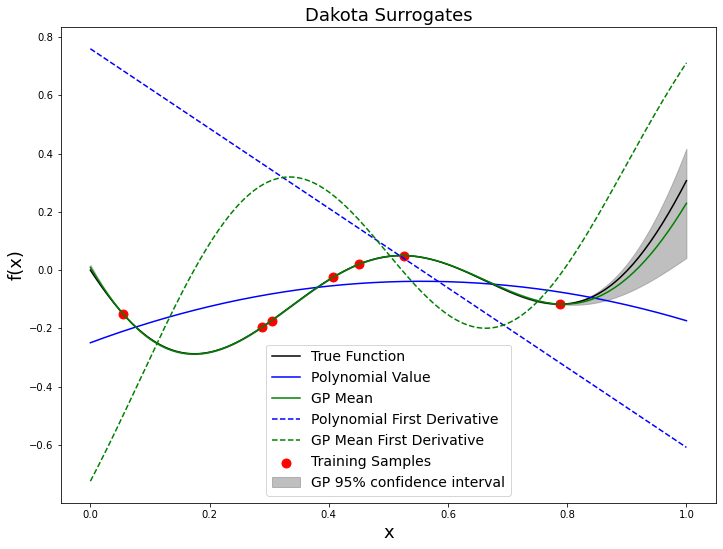

In [5]:
fig1, ax1 = plt.subplots(figsize=(11.75,8.75))
ax1.set_xlabel("x", fontsize=18)
ax1.set_ylabel("f(x)", fontsize=18)
ax1.set_title("Dakota Surrogates", fontsize=18)
ax1.plot(ps, tf(ps), color="black", label="True Function", zorder=1)
# Plot training data
ax1.scatter(xs, ys, color="red", label="Training Samples", 
            marker="o", s = 80, zorder=2)
# Plot polynomial function evals
ax1.plot(ps, poly_value, color="blue", label="Polynomial Value", zorder=3)
# Plot GP function evals (i.e. the GP mean)
ax1.plot(ps, gp_value, color="green", label="GP Mean", zorder=3)
# Plot GP confidence 95% interval using the variance
sig = np.sqrt(gp_variance)
ax1.fill_between(ps.squeeze(), gp_value - 1.96 * sig,
                 gp_value + 1.96 * sig, alpha=.5, color="gray",
                 label='GP 95% confidence interval',
                 zorder=0)
# Plot the 1st derivatives of the polynomial and GP models
ax1.plot(ps, poly_grad, color="blue", label="Polynomial First Derivative", zorder=3, linestyle="--")
ax1.plot(ps, gp_grad, color="green", label="GP Mean First Derivative", zorder=3, linestyle="--")

#ax1.plot(ps, poly_hessian, color="blue", label="Polynomial Second Derivative", zorder=3, linestyle=":")
#ax1.plot(ps, gp_hessian, color="green", label="GP Mean Second Derivative", zorder=3, linestyle=":")

ax1.legend(loc="best",fontsize=14)

## Save and load the surrogates

Finally, we demonstrate saving the models to disk, reloading them, and verifying that they produce the same evaluations. Surrogates built during a Dakota study can also be loaded and evaluated.

In [6]:
# save surrogates
daksurr.save(poly, "poly.txt", False) # text archive
daksurr.save(gp, "gp.bin", True) # binary archive

In [7]:
# load serialized surrogates and compare values
poly_loaded = daksurr.load("poly.txt", False)
gp_loaded = daksurr.load("gp.bin", True)

assert(np.allclose(poly_loaded.value(ps), poly_value))
assert(np.allclose(gp_loaded.value(ps), gp_value))